In [1]:
#| default_exp activations

We're missing a way to look inside a model, while training, to diagnose problems.
Without this ability people often randomly try things until something starts working..
We're going to do it properly.

# Activation stats

In [2]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from functools import partial
import matplotlib as mpl
from datasets import load_dataset
from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

We imported what we just created in the learner.  

We define `set_seed()` with 3 random number generators: Pytorch's, Numpy's, and Python's, and seed all of them.
In Pytorch we can ask it to use a deterministic algorithm, so things should be reproducible.
We shouldn't always make things reproducible, but for lessons this is useful.

In [3]:
#|export
def set_seed(seed=42, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Dataset

Lets use the `fashion_mnist` data set, load it, and create a model similar to our previous models. (might be a bit bigger).

In [4]:
from datasets import load_dataset,load_dataset_builder
name = 'fashion_mnist'
x,y = load_dataset_builder(name).info.features
dsd = load_dataset(name)
bs = 1024
num_classes=len(load_dataset_builder(name).info.features["label"].names)

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## Baseline

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

Let's use `MulticlassAccuracy` and the same callbacks that we used before, and the trainCB version (for no particular reason).

In [6]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.aggregation import MeanMetric as Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=num_classes))
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

Training at a high learning rate (LR) allows for faster convergence and reduced overfitting, as each data item is seen less often. 
Let's test a high LR of 0.6. 
The `fit()` function creates a Learner `learn` with our callbacks `cbs` (adding `xtra_cbs`), fits the model, and returns the Learner for potential future use.

In [7]:
def fit(model, epochs=2, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

Below it is training and then it suddenly "falls apart", going well for a while, and then it stopped traning.
Now we have a graph to investigate.

accuracy,loss,epoch,train
0.157,2.301,0,train
0.198,2.168,0,eval
0.329,1.841,1,train
0.633,1.002,1,eval


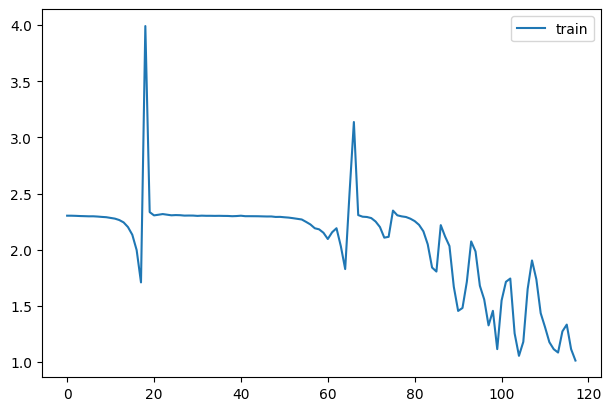

In [8]:
set_seed(1)
learn = fit(model=nn.Sequential(*cnn_layers()), epochs=2)

In above graph we see when it stops training well.
Why did it go badly? Was it because of our high LR? 
Let's try to look inside it to find out.

## Hooks

### Manual insertion
One way to "look inside" is to create a `SequentialModel` class,
compute for each layer its `mean()` and standard deviation `std()`, 
and append them to a couple of lists, `act_means` and `act_stds`. 
We define `__iter__` to make this class an iterator, to iterate through the layers.

In [9]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        # Register layers as submodules so they're tracked by PyTorch
        self.layers = nn.ModuleList(layers)
        
        # Initialize storage for activation means and stds per layer
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]

    def forward(self, x):
        # Standard forward method used during model calls (model(x))
        for i, layer in enumerate(self.layers):
            x = layer(x)  # Apply each layer in sequence
            # Record mean and std of activations after this layer
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x  # Final output

    def __iter__(self):
        # Allow: for layer in model
        return iter(self.layers)

We train this model and it produces an identical output and plots, as we use the same `seed` as before.

accuracy,loss,epoch,train
0.138,2.305,0,train
0.325,2.245,0,eval
0.300,1.972,1,train
0.469,1.313,1,eval


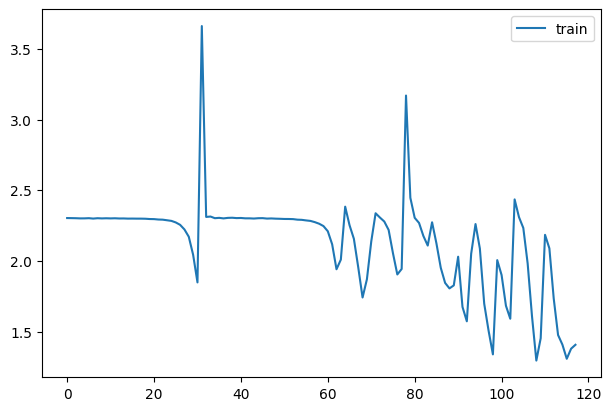

In [10]:
set_seed()
model=SequentialModel(*cnn_layers())
learn = fit(model=model)

We saved the means and standard deviations of each layer's activations per batch, allowing us to plot them. 
The plot shows batch number on the x-axis and activation means for each layer in different colors on the y-axis.

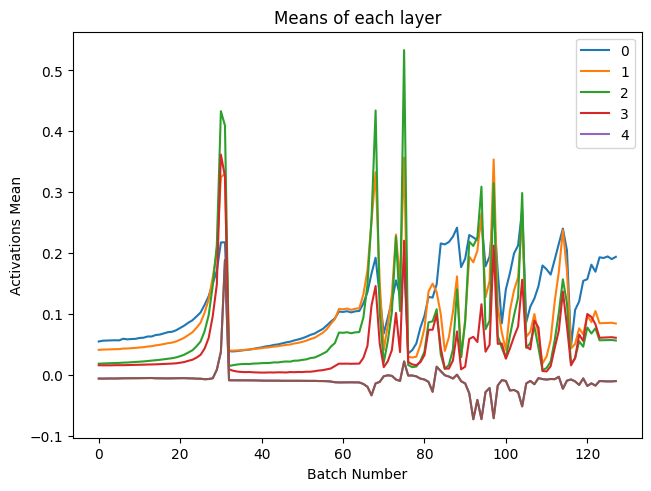

In [11]:
plt.title('Means of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Activations Mean')

for l in model.act_means: plt.plot(l)  # plot each layer
plt.legend(range(5));  #layer labels

The activations started near zero, exponentially increased, and then crashed repeatedly. 
When activations are near zero, the layer outputs are also near zero due to matrix multiplication, resulting in "dead" units that aren't contributing. 
A mean of zero is acceptable **if the values are spread around zero**, but after batch 30, the activations remained close to zero, indicating inactive units.

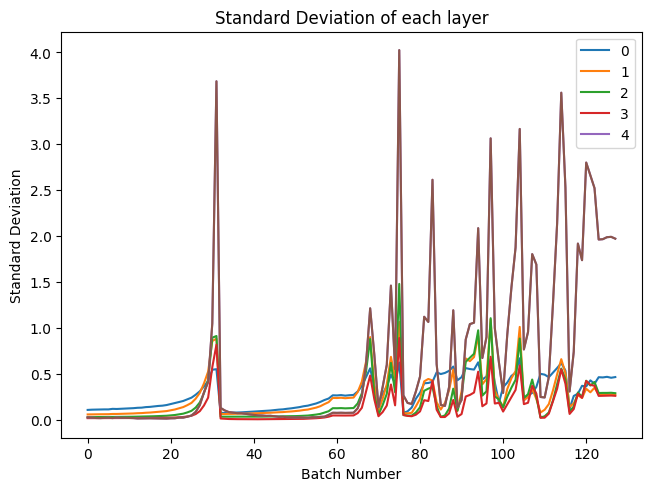

In [12]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));
plt.title('Standard Deviation of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Standard Deviation');

The standard deviations reveal a concerning pattern. 
Ideally, activations should have meaningful variation, but instead, they're all similar, indicating a lack of activity. 
As training progresses, both activations and standard deviations become stagnant.
Moreover, the standard deviations follow a troubling pattern: 
starting with low variety, exponentially increasing, and then crashing. 
This cycle repeats, which is a classic sign of unstable training behavior.
<mark> This is a classic shape of bad behavior.</mark>
<br>
Ideally, we want the the activations $means \approx 0$ and the $stds \approx 1$.
A standard deviation $\approx 0$ is terrible, because all activations are about the same.

Above 2 plots explain what's going on in the model.
After we train a model we can look at such plots to see if the model is training "nicely" ("nice" training pictures later).
If the mean is always about 0 and the variance always about 1,
there is a good chance we're training properly, else, we're certainly not.

### Pytorch hooks

Now lets do this in a more elegant way, with Pytorch hooks, an object that we can add to any `nn.Module` to inject a piece of custom functionality.
A **forward/backward hook** is called when a registered layer is executed during the forward/backward pass. 
Forward Hooks can be used to inspect intermediate outputs or even modify them.
Backward Hooks can be used to inspect gradients flowing backward or even modify them.
Using hooks we don't have to rewrite the model, we can add them to any existing model.
They can be useful for a variety of purposes, including:
- Debugging: to inspect values or gradients at specific layers.
- Gradient clipping or modification: to modify gradients during backpropagation, which can be useful in certain training scenarios.
- Feature visualization: to extract intermediate representations for visualization or further processing.

Pytorch "hooks" and callbacks are very similar.
Hooks are less flexible than the Learner's callbacks 
because hooks don't have access to all the available states, hence can't change things.
Hooks are a kind of callback that just sets a function to be run when something happens, 
e.g., a layer in the forward or backward pass.
(We can say the function that's being called back is the Callback, and the thing that's doing the Callback is the hook.)
<br>
Lets use a standard `nn.Sequential` passing in the `cnn_layers`.

In [13]:
set_seed()
model = nn.Sequential(*cnn_layers())

To keep track of the activation means and standard deviations, we create empty lists for means and stds for each layer in the model.

In [14]:
act_means = [[] for _ in model] # creates a new list of (number of elements in the model) empty lists. 
act_stds  = [[] for _ in model]

A hook function needs to have a function signature that takes 3 arguments: module `mod`, input `inp`, output `outp`. 
`append_stats` store the outputs `mean()` in `act_means` and the output standard deviation in `act_std`.
It will be "attached" to the layers using `partial` to match the needed signature.

In [15]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

For each layer of the model we call [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=register#torch.nn.Module.register_forward_hook) to register a function that will be called every time a `forward()` has computed an output.
`append_stats` is the hook function that will be called, passing `i` as the first argument (via `partial`).
<br>
NB: partial (provided by functools) allows to "freeze" some portion of a function's arguments and keywords, resulting in a new function with fewer arguments. This is particularly useful when you want to "fix" certain arguments of a function and pass it around as a callback with a specific signature.

In [16]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

We now fit that model, it trains in the usual way, but after each layer it's
going to call the `append_stats` hook.

accuracy,loss,epoch,train
0.138,2.305,0,train
0.325,2.245,0,eval
0.300,1.972,1,train
0.469,1.313,1,eval


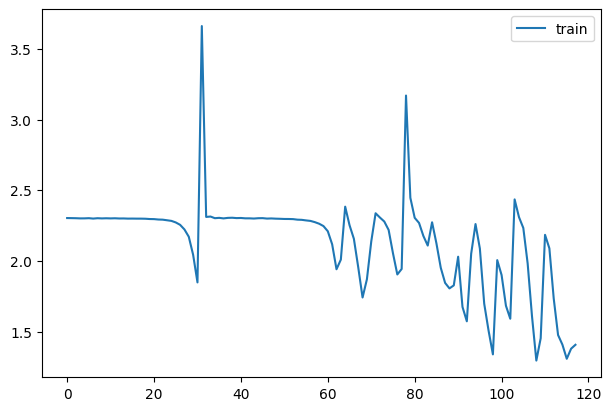

In [17]:
fit(model);

We get the same results and plot as before, but now we can also take a look at the statistics.

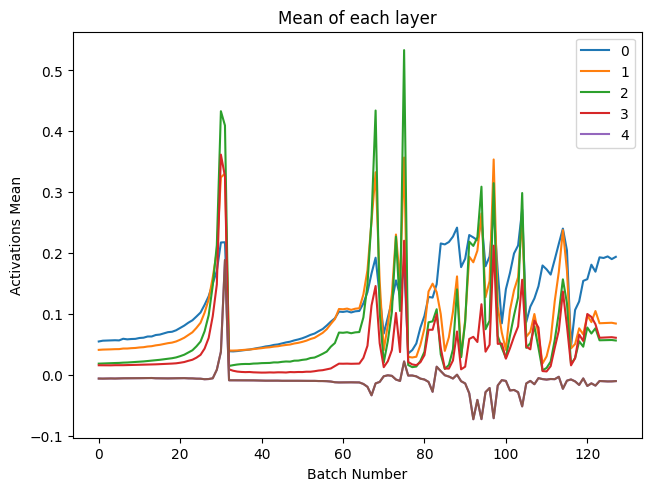

In [18]:
for o in act_means: plt.plot(o)
plt.legend(range(5));
plt.title('Mean of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Activations Mean');

### Hook class

Lets refactor and define a Hook class. 
For module `m`, m[.register_forward_hook](https://pytorch.org/docs/stable/generated/torch.jit.ScriptModule.html?highlight=register_forward#torch.jit.ScriptModule.register_forward_hook) registers a forward hook,
with the (callback) function, e.g., `f=append_stats`, and the class via `self`.
We define a `remove()` method to remove the hooks when they are deleted, otherwise memory won't be released when the model is deleted. 
The `__del__` is called by Python when an object is freed, so we make sure that we remove this hook.

In [19]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

The new `append_stats` will get the hook (`f` we asked to be passed above).
If there's no `stats` attribute yet `not hasattr(hook,'stats')` then let's create one inside this object (is convenient).
The `outp` activations are put in `acts` on the CPU, then `.append` to the `stats` the `acts` `.mean()` and `.std()`.

In [20]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [21]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We instantiate `hooks` for each `l`, of the first 5 `children()` modules of the `model`, each being the same `append_stats`.

In [22]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

Now we can do the same "thing" as before but we don't have to set any `Global` stuff.
When we `fit(model)` it's going to run with the hooks.

accuracy,loss,epoch,train
0.157,2.301,0,train
0.198,2.168,0,eval
0.329,1.841,1,train
0.633,1.002,1,eval


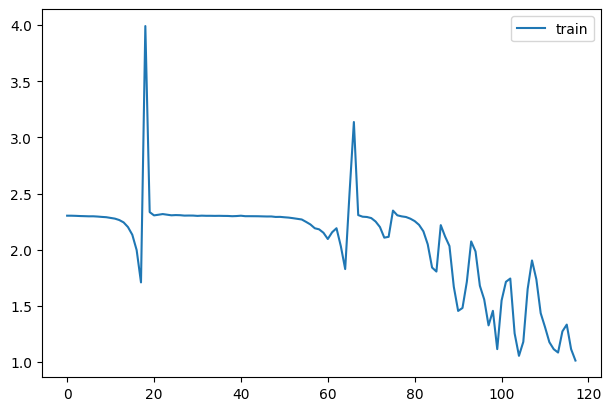

In [23]:
learn = fit(model)

Now we can see e.g., the means of the layers., and confirm that they have the same shape and results as with the callbacks.

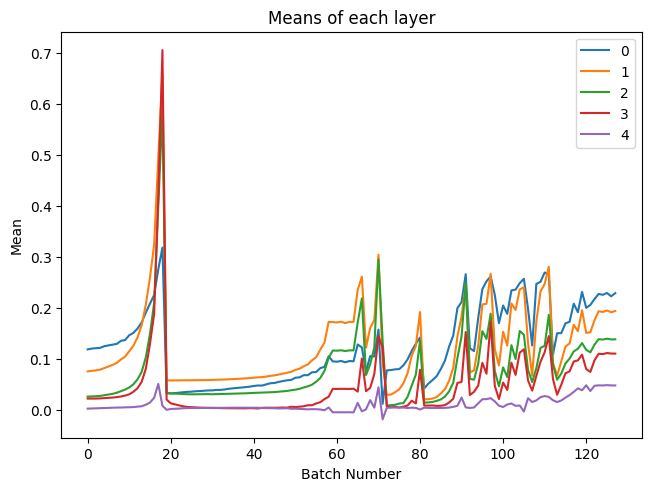

In [24]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));
plt.title('Means of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Mean');

### A Hooks class
To add multiple Hooks, the list comprehension `hooks = [Hook(l, append_stats) for l in model[:5].children()]` is a bit inconvenient.
Let's define a `Hooks` class.
But before that, some preliminaries.

#### Preliminaries

Below is a dummy context manager, `DummyCtxMgr`.
It's got `__enter__` which is going to return `self`, and print something.
The second thing it's going to do is call the `dcm.hello()` code inside the context manager.
`dcm` is itself and so it's going to call `hello(self)` which prints "hello.".
Finally it's going to automatically call `__exit__`  which prints "all done!".

In [25]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

Below we call `with DummyCtxMgr()` and so it prints "let's go!" first, etc.

In [26]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


#### what it's like to inherit from list. 
`DummyList(list)` is inheriting from list and we redefine how `__delitem__` works. 

In [27]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

We create a `Dummylist` as usual.

In [28]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

But if we delete `del` an item (`del(dml[2])`), it calls the overridden `__delitem__` version, which prints a message
and then calls the original `super().__delitem__(i)`
The list got removed that item and did this at the same time.

In [29]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

## The Hooks class

A Python context manager is a class that defines `__enter__` and `__exit__`.
The `Hooks` class (below) inherits from `list`.
*(In Python, we can inherit from stuff like list).*
Because `Hooks` is a subclass of `list`, in `__init__` we need to call the `super()` class Constructor.
We pass-in a list comprehension the hook function `f` and the modules `m` we ask to hook into.
`super().__init__([Hook(m, f) for m in ms])`.
<br>
We're passing in a `nn.sequential` model, hence we can loop through it and it returns each of the layers.
`__exit__` is called automatically at the end of the whole block.
It calls `remove` that removes each hook `h`.
We also added an optional `__delitem__` to delete a single `Hook` from the list.

In [30]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [31]:
set_seed()
model = nn.Sequential(*cnn_layers())

Let's explore the `Hooks` class as a context manager. 
We pass the `model` and `append_stats` function to it, then call `fit(model)`. 
When entering the with block, `__enter__` is called, returning the `Hooks` object itself, which can be stored in a variable like `hooks`. 
With a single line of code, `with Hooks(model, append_stats) as hooks:`, we can set up the context manager 
and later iterate through each hook to plot the mean and standard deviation stats of each layer.

accuracy,loss,epoch,train
0.138,2.305,0,train
0.325,2.245,0,eval
0.300,1.972,1,train
0.469,1.313,1,eval


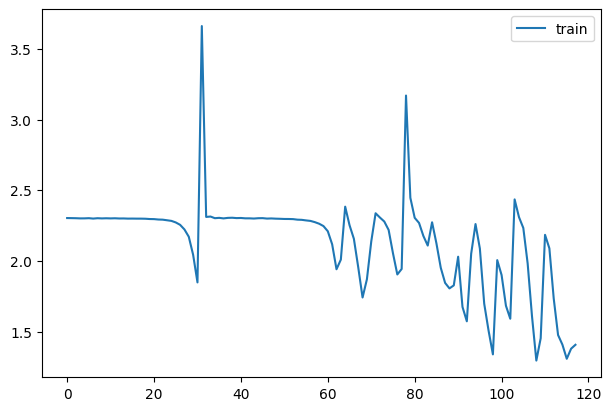

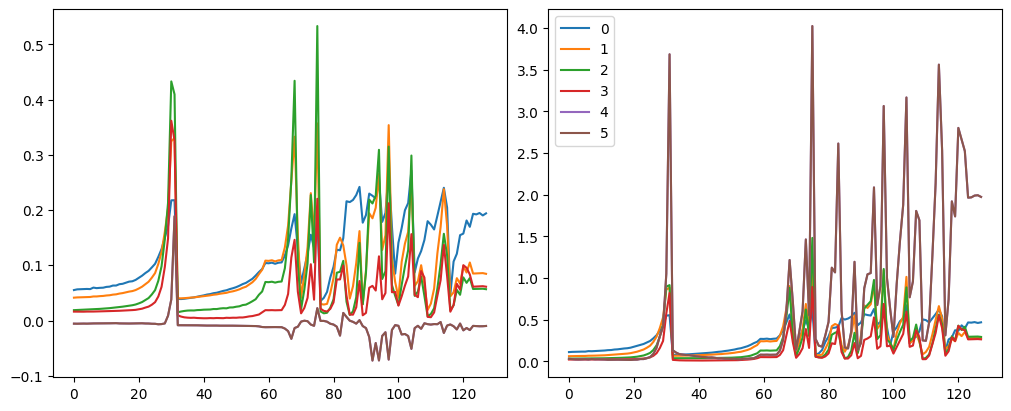

In [33]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i]) 
    plt.legend(range(6));

### HooksCallback

We refactored the `Hooks` class into a `HooksCallback(Callback)` for simplicity. 
The `__init__` constructor takes a hook function (`hookfunc`) and an optional module filter (`mod_filter`). 
In `before_fit`, it filters the learner's modules based on the filter. 
A `_hookfunc` checks conditions for training or validation and calls `hookfunc` if met. 
After fitting, `after_fit` removes the hooks. 
The callback also allows iteration and length checking of the hooks.

In [34]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

Lets create a hooks callback`hc`, with `append_stats`, and a filter to apply i.e., only the `conv2d` layers.
`fc.risinstance` is "Curried `isinstance` but with args reversed".

In [35]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [36]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We add `hc` as an extra callback `xtra_cbs` to `fit`. 
Now we can iterate through it and plot in the usual way.

accuracy,loss,epoch,train
0.157,2.301,0,train
0.198,2.168,0,eval
0.329,1.841,1,train
0.633,1.002,1,eval


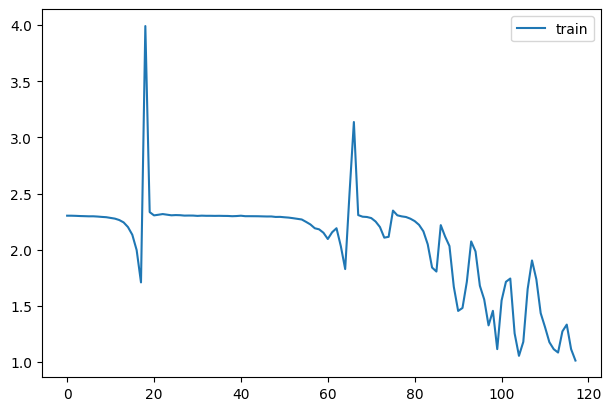

In [37]:
fit(model, xtra_cbs=[hc]);

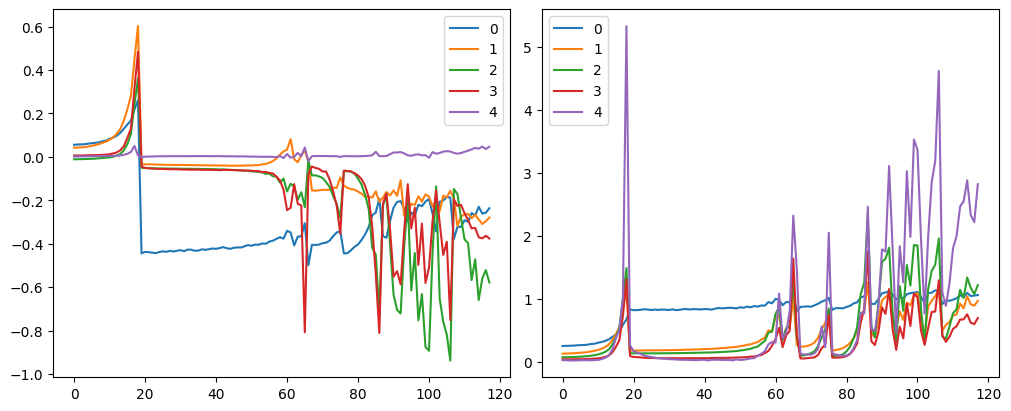

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in (0, 1):
        axs[i].plot(h.stats[i])

# Set legend on both subplots (or just one)
for ax in axs:
    ax.legend(range(6))  # adjust if fewer than 6 lines per subplot

## Histograms - the *colorful dimension*

We're exploring what's happening inside a model using **colorful dimension** histograms. 
We use `append_stats` with [torch.histc](https://pytorch.org/docs/stable/generated/torch.histc.html) 
to create histograms of absolute activation values, showing the frequency of different value ranges. 
Specifically, `acts.abs().histc(40, 0, 10)` generates a histogram with 40 bins between 0 and 10, 
counting the values in each range. 
We'll use this approach with the hooks to define a new version of `append_stats`.

In [39]:
#|export
def append_stats(hook, module, input, output):
    """
    Hook function to record statistics of a module's output during forward pass.

    Records:
      - Mean of activations
      - Standard deviation of activations
      - Histogram (absolute value of activations, 40 bins in [0,10])

    These stats are appended to a `hook.stats` attribute, which is a tuple of three lists.
    """
    # Initialize storage on first call
    if not hasattr(hook, 'stats'):
        # stats = (means, stds, histograms)
        hook.stats = ([], [], [])

    # Ensure tensor is detached and moved to CPU for safe processing
    acts = to_cpu(output)

    # Compute and append statistics
    hook.stats[0].append(acts.mean().item())  # scalar: mean of activations
    hook.stats[1].append(acts.std().item())   # scalar: std of activations
    hook.stats[2].append(acts.abs().histc(bins=40, min=0, max=10))  # histogram tensor


so it's going to train as before, but now in addition it will have in `stats[2]` a histogram.

accuracy,loss,epoch,train
0.157,2.301,0,train
0.198,2.168,0,eval
0.329,1.841,1,train
0.633,1.002,1,eval


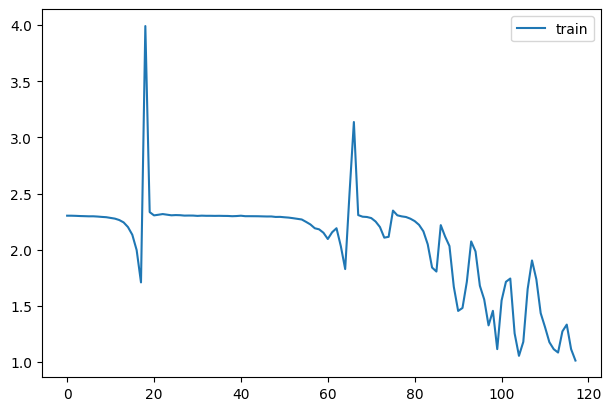

In [40]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

`get_hist(h)`
Takes the histograms, stacks them all up into a single tensor, and then took their `log1p`,  log1p(x) = log(x+1).
That's because we've got zeros here and so just taking the log is going to let us see the full range more clearly.

In [41]:
#|export
# Thanks to @ste for initial version of histogram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

The plot below show for each of the layers what does the training "look like".
There is some pattern among them, but what is this pattern showing?
We turn the histogram into a single column of pixels, i.e., one column of pixels is one histogram.
<sub><sup>
NB: See video for this example:
We take the numbers of the histogram, e.g., 14 2 7 9 11 3 2 4 2. 
We turn it into a single column, in this case there are 9 numbers so we have nine groups.
We take the first group (it's 14) and we color it with a gradient according to how big that number is.
14 is a big number, so we use red. 
Next (2) really small which might be green.
Then (7) in the middle blue, (9) is bigger red, (11) bigger more red, and so forth.
</sub></sup>

In [42]:
def color_dim(hc, figsize=(12, 6)):
    """
    Visualizes activation histograms for a list of hook objects.

    Each hook `h` is expected to contain `h.stats[2]`, which is a list of histograms
    (as returned by `torch.histc`) representing the absolute value of activations per forward pass.

    Args:
        hc (list): List of hook objects with `.stats[2]` containing histogram tensors.
        figsize (tuple): Size of the matplotlib figure (width, height).
    """
    # Create a grid of subplots sized to fit the number of hooks
    fig, axes = get_grid(len(hc), figsize=figsize)

    # Iterate over axes and corresponding hooks
    for ax, h in zip(axes.flat, hc):
        # Stack list of 1D histograms into a 2D array (time x bin)
        hist_array = get_hist(h)  # shape: [steps, bins]
        # Show the histogram as an image
        show_image(hist_array, ax, origin='lower')

    return fig, axes  # optional: return for further use

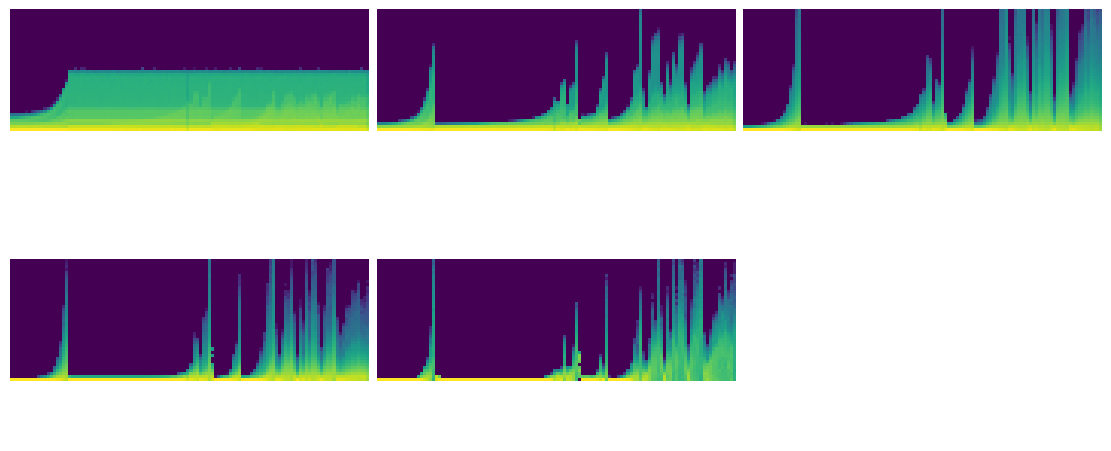

In [43]:
_ = color_dim(hc, figsize=(11,5))

We are taking the histogram and making it into a color-coded single column plot.
Let's take a layer, number two.
We can take the very first column and so in the color
scheme that matplotlib picked, yellow is the most common, then light green is less common,
and then light blue, and then dark blue is zero.
The vast majority is zero and there's a few with slightly bigger numbers, the same that we saw earlier.
The average is close to zero, the standard deviation is small.
This is giving us more information, so as we train at (first peak)
quite a few activations that are a lot larger, still the vast majority of them are very small.
But there's a few big ones so it has a bright yellow bar at the bottom.

<mark>Ideally we want to see here is more like a rectangle.
The maximum should not be changing very much.
There shouldn't be a thick yellow bar at the bottom, but instead it should be a nice even gradient, matching a normal distribution.
Each single column of pixels wants to have a normal distribution, gradually decreasing the number of activations.
That's what we're aiming for.
</mark>

Another way is to take the ratio of the very first smallest histogram bin to the rest of the bins, `h1[0]/h1.sum(0)`.
These are very *dead* at this point. 
Taking this ratio tells us what percentage have (near) zero or extremely small magnitudes.
These are absolute values so if we plot those we can see how bad this is.
For example the final layer from the very start nearly all of the activations are disabled.
If most of our model is close to 0 then most of it is doing no work.
So it may look like at the very end things were improving...
But as you can see from this chart that's not true, the vast majority are inactive.
<br>
<mark>If early in training we see a rising, crash, rising, crash pattern, we should stop and restart training.</mark>
Such a model will probably never recover, as too many of the activations have "gone off the rails".
<sup><sub>
So we want it to look kind of like this the whole time but with less of this very thick yellow bar which is showing us most are inactive.
</sup></sub>

In [44]:
#|export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

so the graphs really look like very dead at this point.

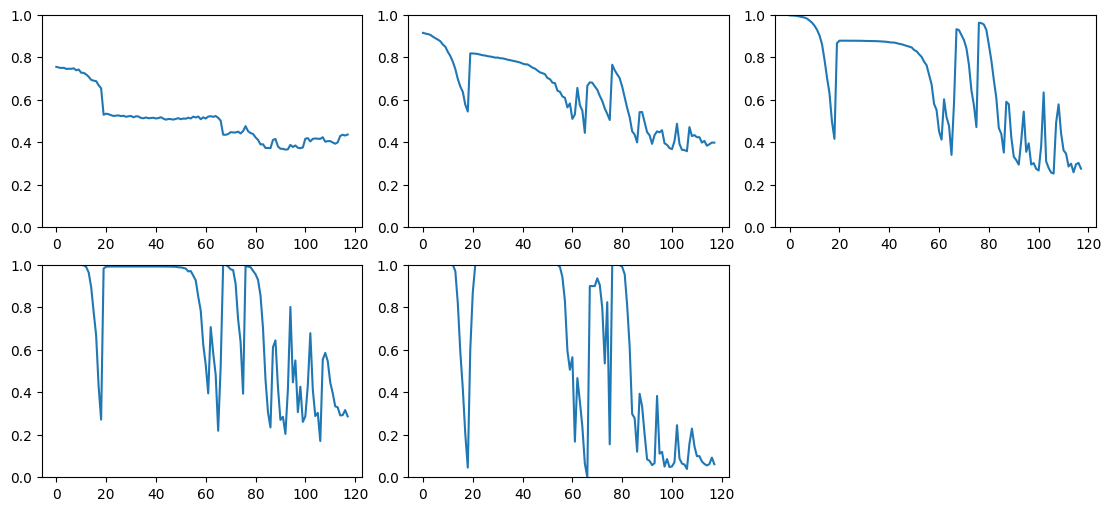

In [45]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

Lets take `color_dim` and wrap it in a callback: `ActivationStats(HooksCallback)`
which uses `append_stats` to append the means, stds and histograms.
Added the `color_dim` method, a `dead_chart` method and a `plot_stats` method.

In [46]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):   # Stack list of 1D histograms into a 2D array (time x bin) and show histogram
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

To see them at work, if we want to get the activations on and all of the cons, 
then we train our model, created our `ActivationStats`, added `astats` as an extra callback,
and then we can call `astats.color_dim(), astats.dead_chart()` and `astats.plot_stats()` to get each plot.

In [47]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.157,2.301,0,train
0.198,2.168,0,eval
0.329,1.841,1,train
0.633,1.002,1,eval


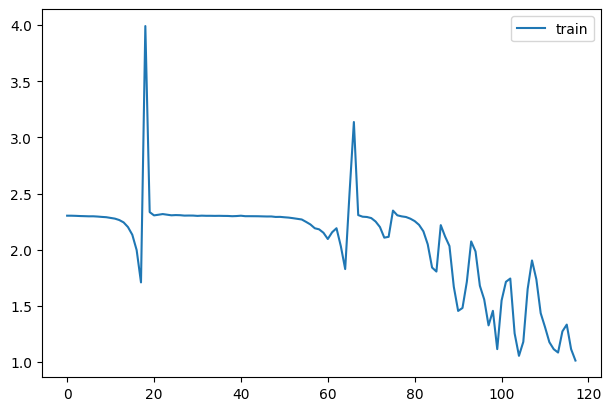

In [48]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

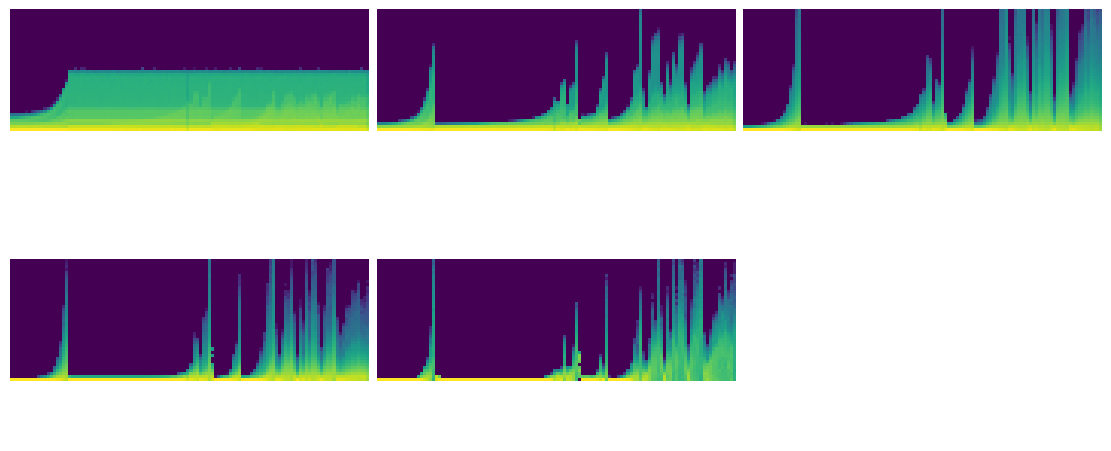

In [49]:
astats.color_dim()

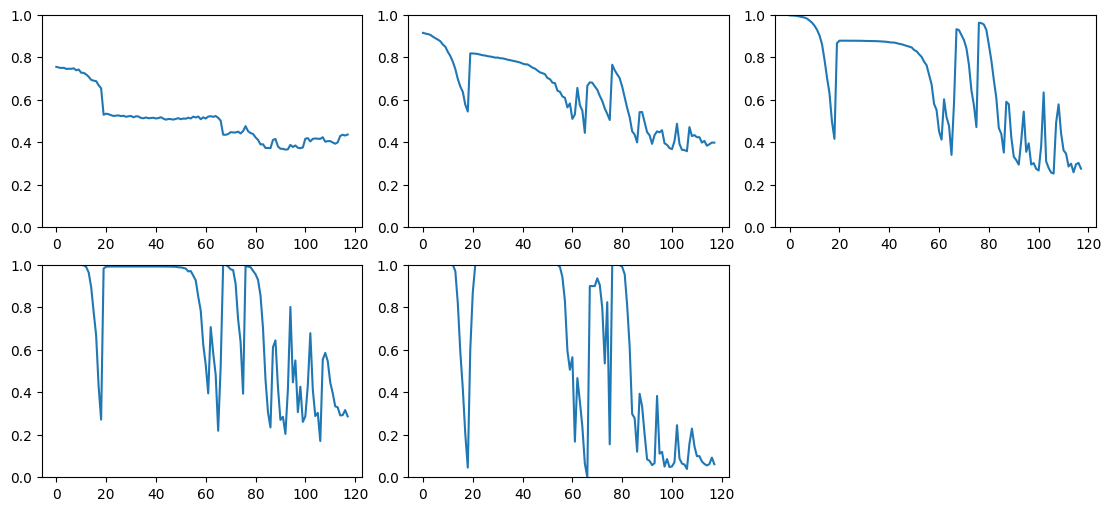

In [50]:
astats.dead_chart()

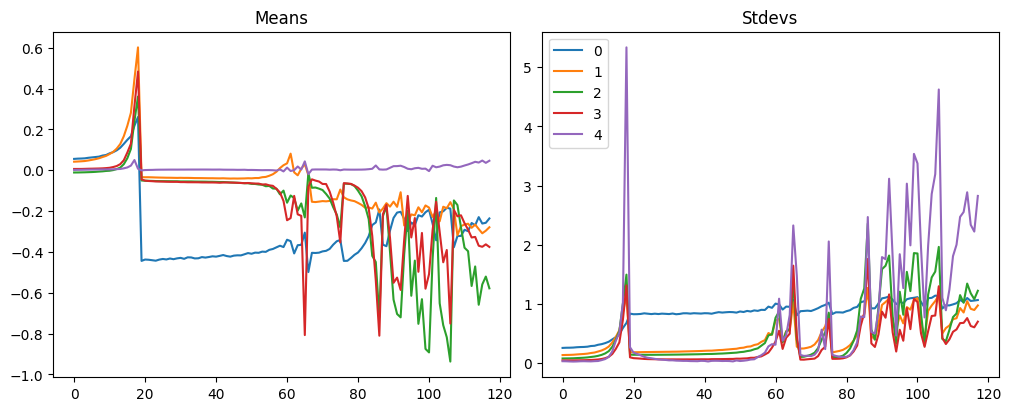

In [51]:
astats.plot_stats()

Now we can get all of these informative visualizations of what's going on inside our model. 
It's just adding one line of code and putting that in our callbacks.
Even for models we thought were training really well we can try using this and
might be surprised to discover that they're not ... 

## Export -

In [52]:
import nbdev; nbdev.nbdev_export()